In [2]:
import sys
sys.path.append('../..')
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from qubap.qiskit.hamiltonians import test_hamiltonian
from qubap.qiskit.variational_algorithms import classical_solver

In this tutorial we are going to implement a VQE with all the features of our module, that is, an pretrained adiabatic VQE with State Efficient Ansatz. We will use the following 10-qubits hamiltonian 

In [29]:
num_qubits = 10
H = test_hamiltonian( num_qubits )
print(H)

0.9990234375 * IIIIIIIIII
- 0.0009765625 * IIIIIIIIIZ
- 0.0009765625 * IIIIIIIIZI
- 0.0009765625 * IIIIIIIIZZ
- 0.0009765625 * IIIIIIIZII
- 0.0009765625 * IIIIIIIZIZ
- 0.0009765625 * IIIIIIIZZI
- 0.0009765625 * IIIIIIIZZZ
- 0.0009765625 * IIIIIIZIII
- 0.0009765625 * IIIIIIZIIZ
- 0.0009765625 * IIIIIIZIZI
- 0.0009765625 * IIIIIIZIZZ
- 0.0009765625 * IIIIIIZZII
- 0.0009765625 * IIIIIIZZIZ
- 0.0009765625 * IIIIIIZZZI
- 0.0009765625 * IIIIIIZZZZ
- 0.0009765625 * IIIIIZIIII
- 0.0009765625 * IIIIIZIIIZ
- 0.0009765625 * IIIIIZIIZI
- 0.0009765625 * IIIIIZIIZZ
- 0.0009765625 * IIIIIZIZII
- 0.0009765625 * IIIIIZIZIZ
- 0.0009765625 * IIIIIZIZZI
- 0.0009765625 * IIIIIZIZZZ
- 0.0009765625 * IIIIIZZIII
- 0.0009765625 * IIIIIZZIIZ
- 0.0009765625 * IIIIIZZIZI
- 0.0009765625 * IIIIIZZIZZ
- 0.0009765625 * IIIIIZZZII
- 0.0009765625 * IIIIIZZZIZ
- 0.0009765625 * IIIIIZZZZI
- 0.0009765625 * IIIIIZZZZZ
- 0.0009765625 * IIIIZIIIII
- 0.0009765625 * IIIIZIIIIZ
- 0.0009765625 * IIIIZIIIZI
- 0.0009765625 * IIIIZ

In [5]:
exact_min_energy = classical_solver(H).eigenvalue
exact_min_energy

0j

First we are going to do a standard VQE with `EfficientSU2` with a single layer of entangling gates as parametric circuit.

In [6]:
from qiskit.circuit.library import EfficientSU2
from qubap.qiskit.variational_algorithms import VQE, energy_evaluation 
from qiskit_aer import AerSimulator

In [7]:
num_reps = 1
ansatz = EfficientSU2( num_qubits, ['ry','rz'], 'circular', num_reps).decompose()

We start the search from a random point.

In [9]:
np.random.seed(102)
initial_guess = np.random.randn( ansatz.num_parameters )*np.pi
num_iters     = 300
backend       = AerSimulator( shots=2**8 )

In [ ]:
results_vqe = VQE( H, ansatz, initial_guess, num_iters, backend )
analitic_results_vqe = [ energy_evaluation( H, ansatz, x, AerSimulator(method='statevector') ) for x in results_vqe['x'] ]

We obtain the following results. Clearly, this problem exhibits a barren plateau.  

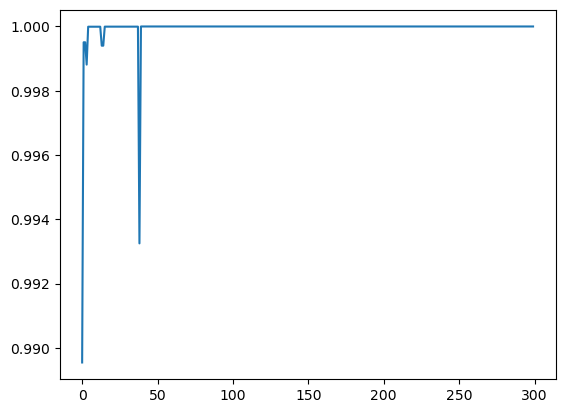

In [11]:
plt.plot( analitic_results_vqe )

Now, we create the local Hamiltonian.

In [12]:
from qubap.qiskit.cost_function_barren_plateau import global2local

In [13]:
H_local = global2local( H )
print( H_local )

0.49999999999988654 * IIIIIIIIII
- 0.05000000000000045 * ZIIIIIIIII
- 0.05000000000000045 * IZIIIIIIII
- 0.05000000000000045 * IIZIIIIIII
- 0.05000000000000045 * IIIZIIIIII
- 0.05000000000000045 * IIIIZIIIII
- 0.05000000000000045 * IIIIIZIIII
- 0.05000000000000045 * IIIIIIZIII
- 0.05000000000000045 * IIIIIIIZII
- 0.05000000000000045 * IIIIIIIIZI
- 0.05000000000000045 * IIIIIIIIIZ


Next, perform the pretraining with matrix product states.

In [14]:
from qubap.qiskit.mps_pretraining import Ansatz, VQE_pretrain

In [15]:
ansatz_mps = Ansatz( num_qubits, diagonal=True )

In [17]:
num_iters_train = 300
results_pretrain = VQE_pretrain( H, num_iters_train )

Finally, we construct the state-efficient ansatz. Notice that we compose the state-efficient ansatz with the optimal MPS ansatz in order to start the optimization from the pretraining. 

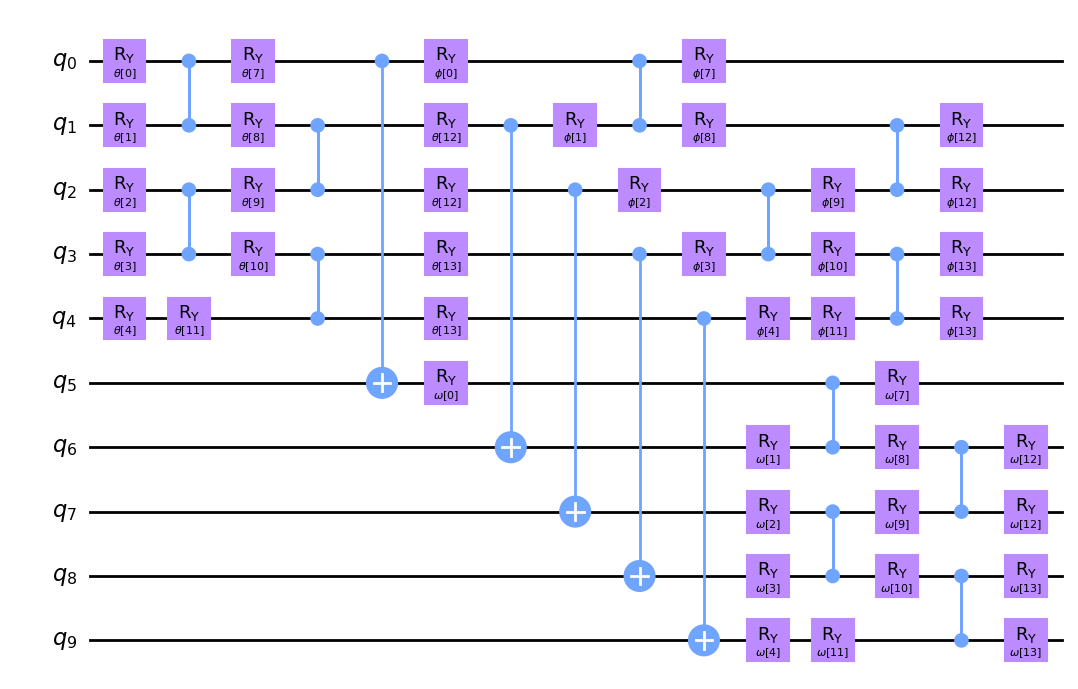

In [35]:
from qubap.qiskit.state_efficient_ansatz import ansatz_constructor 
num_reps_sea = 1
ansatz_sea   = ansatz_constructor( num_qubits, deep=[num_reps_sea,num_reps_sea,num_reps_sea]).decompose()
ansatz_sea.draw( 'mpl', fold=-1 )

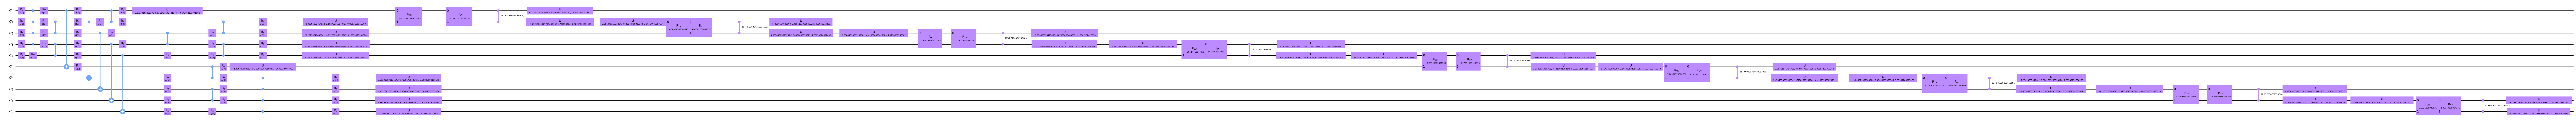

In [34]:
ansatz_sea_mps = ansatz_sea.compose( ansatz_mps.bind_parameters(results_pretrain['x'][-1]) ).decompose()
ansatz_sea_mps.draw( 'mpl', fold=-1 )

Executing the adiabatic VQE.

In [23]:
from qubap.qiskit.variational_algorithms import VQE_adiabatic

In [ ]:
initial_guess = np.zeros( ansatz_sea_mps.num_parameters ) + 0.01
results_adiabatic = VQE_adiabatic( H_local, H, ansatz_sea_mps, initial_guess, num_iters, backend )

In [25]:
analitic_results_adiabatic   = [ energy_evaluation( H, ansatz_sea_mps, x, AerSimulator(method='statevector') ) for x in results_adiabatic['x'] ]

We can see that the combined routine is able of outperformed the barren plateau.

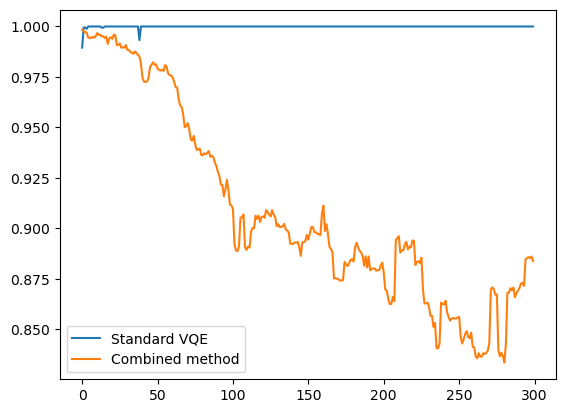

In [28]:
plt.plot( analitic_results_vqe )
plt.plot( analitic_results_adiabatic )
plt.legend(['Standard VQE', 'Combined method'])

In [36]:
import qiskit.tools.jupyter
%qiskit_version_table